<a href="https://colab.research.google.com/github/dakilaledesma/FSUS_Tools/blob/main/notebooks/Plant_Extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
! pip install rectangle-packing-solver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 12.4 MB/s 
     |████████████████████████████████| 957 kB 67.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [2]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.10.0+cu111 torchvision==0.11.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
# !pip install mmcv-full
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html

# Install mmdetection
!pip install mmdet
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git

# !pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████▌                   | 834.1 MB 1.2 MB/s eta 0:17:53tcmalloc: large alloc 1147494400 bytes == 0x3986e000 @  0x7f182803f615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |███████████████▉                | 1055.7 MB 1.2 MB/s eta 0:15:33tcmalloc: large alloc 1434370048 bytes == 0x7dec4000 @  0x7f182803f615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.10.0+cu111 True
2.25.1
11.1
GCC 7.3


In [5]:
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
      -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

--2022-09-12 13:36:17--  https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.187.167
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.187.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177867103 (170M) [application/octet-stream]
Saving to: ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’

checkpoints/mask_rc 100%[===================>] 169.63M  13.0MB/s    in 13s     

2022-09-12 13:36:30 (13.0 MB/s) - ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’ saved [177867103/177867103]



In [6]:
from mmcv import Config
%cd /content
cfg = Config.fromfile('mmdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

/content


In [7]:
%cd /content
! unzip -q /content/drive/MyDrive/UNC/H2022/H2022_COCO.zip -d /content

/content


In [11]:
# from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'CocoDataset'
cfg.data_root = 'H2022_COCO/'

cfg.data.test.type = 'CocoDataset'
cfg.data.test.data_root = 'H2022_COCO/'
cfg.data.test.ann_file = 'annotations.json'
cfg.data.test.img_prefix = 'images'
cfg.data.test.classes = ('plant',)

cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = 'H2022_COCO/'
cfg.data.train.ann_file = 'annotations.json'
cfg.data.train.img_prefix = 'images'
cfg.data.train.classes = ('plant',)

cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = 'H2022_COCO/'
cfg.data.val.ann_file = 'annotations.json'
cfg.data.val.img_prefix = 'images'
cfg.data.val.classes = ('plant',)

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 1
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = '/content/checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.lr_config.policy = 'step'
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'bbox'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
# set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device='cuda'

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cro

In [9]:
import fileinput
import sys

def replacement(file, previousw, nextw):
   for line in fileinput.input(file, inplace=1):
       line = line.replace(previousw, nextw)
       sys.stdout.write(line)

file = "/content/mmdetection/tools/train.py"
replacement(file, "cfg.device = get_device()", "cfg.device = 'cuda'")

In [12]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
import mmcv
import os.path as osp


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
print(model.CLASSES)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
('plant',)


2022-09-12 13:50:08,508 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-09-12 13:50:08,520 - mmdet - INFO - load checkpoint from local path: /content/checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
2022-09-12 13:50:08,656 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from 

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


2022-09-12 13:50:12,793 - mmdet - INFO - Epoch [1][10/68]	lr: 2.500e-03, eta: 0:05:26, time: 0.406, data_time: 0.233, memory: 3311, loss_rpn_cls: 0.0207, loss_rpn_bbox: 0.0227, loss_cls: 0.2764, acc: 89.0137, loss_bbox: 0.1224, loss: 0.4422
2022-09-12 13:50:14,520 - mmdet - INFO - Epoch [1][20/68]	lr: 2.500e-03, eta: 0:03:50, time: 0.175, data_time: 0.012, memory: 3311, loss_rpn_cls: 0.0143, loss_rpn_bbox: 0.0222, loss_cls: 0.0891, acc: 96.7090, loss_bbox: 0.1255, loss: 0.2511
2022-09-12 13:50:16,258 - mmdet - INFO - Epoch [1][30/68]	lr: 2.500e-03, eta: 0:03:17, time: 0.172, data_time: 0.011, memory: 3311, loss_rpn_cls: 0.0217, loss_rpn_bbox: 0.0177, loss_cls: 0.1002, acc: 96.0645, loss_bbox: 0.1479, loss: 0.2875
2022-09-12 13:50:18,023 - mmdet - INFO - Epoch [1][40/68]	lr: 2.500e-03, eta: 0:03:00, time: 0.176, data_time: 0.012, memory: 3397, loss_rpn_cls: 0.0087, loss_rpn_bbox: 0.0282, loss_cls: 0.0672, acc: 97.0215, loss_bbox: 0.1177, loss: 0.2218
2022-09-12 13:50:19,778 - mmdet - IN

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 135/135, 19.6 task/s, elapsed: 7s, ETA:     0s

2022-09-12 13:53:06,066 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2022-09-12 13:53:06,183 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.973
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.925
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.795
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.845
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.845
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.845
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.821
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=10

DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).


In [19]:
! unzip -q drive/MyDrive/UNC/S2022P/GBIF_Q_fourth15.zip -d /content/temp
! mv /content/temp/content/dataset/train /content/train
! mv /content/temp/content/dataset/test /content/test
! rm -rf /content/temp

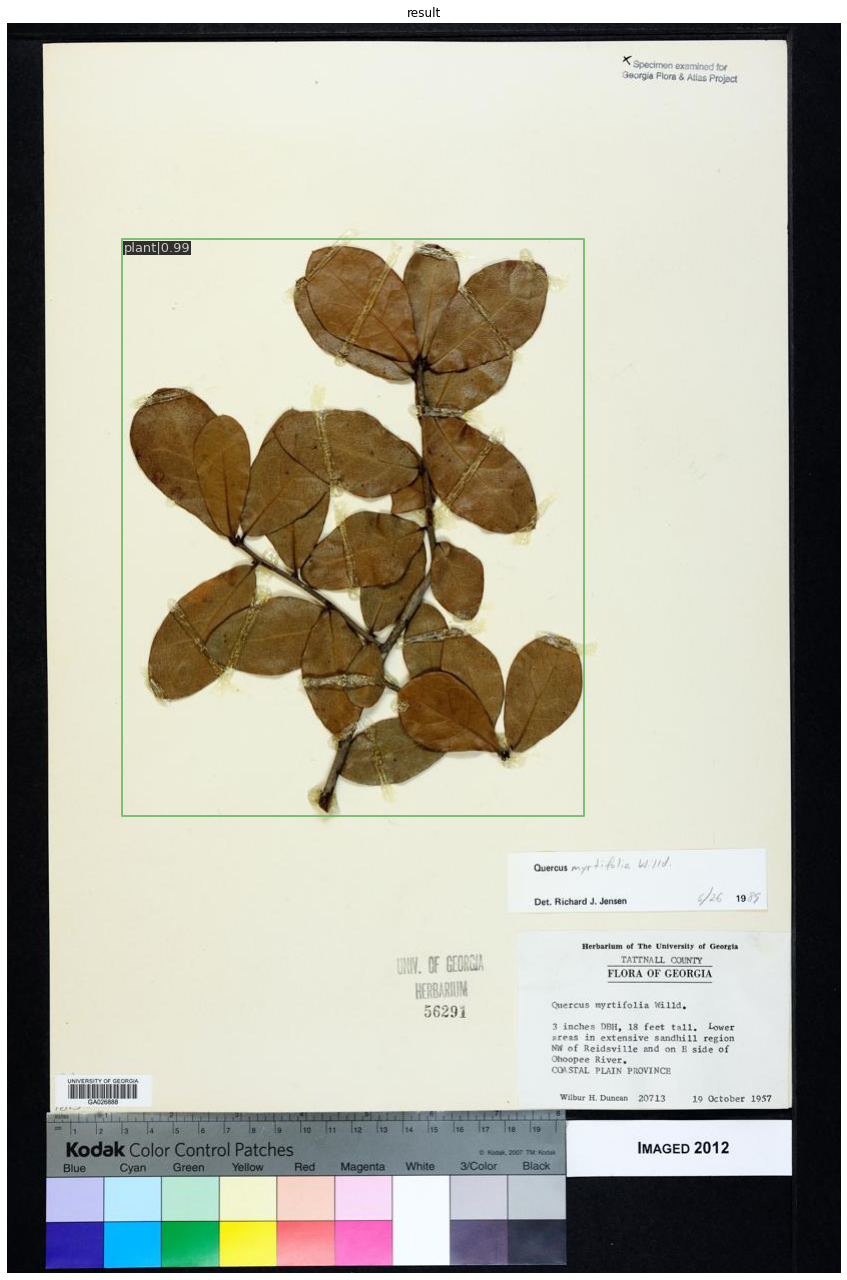

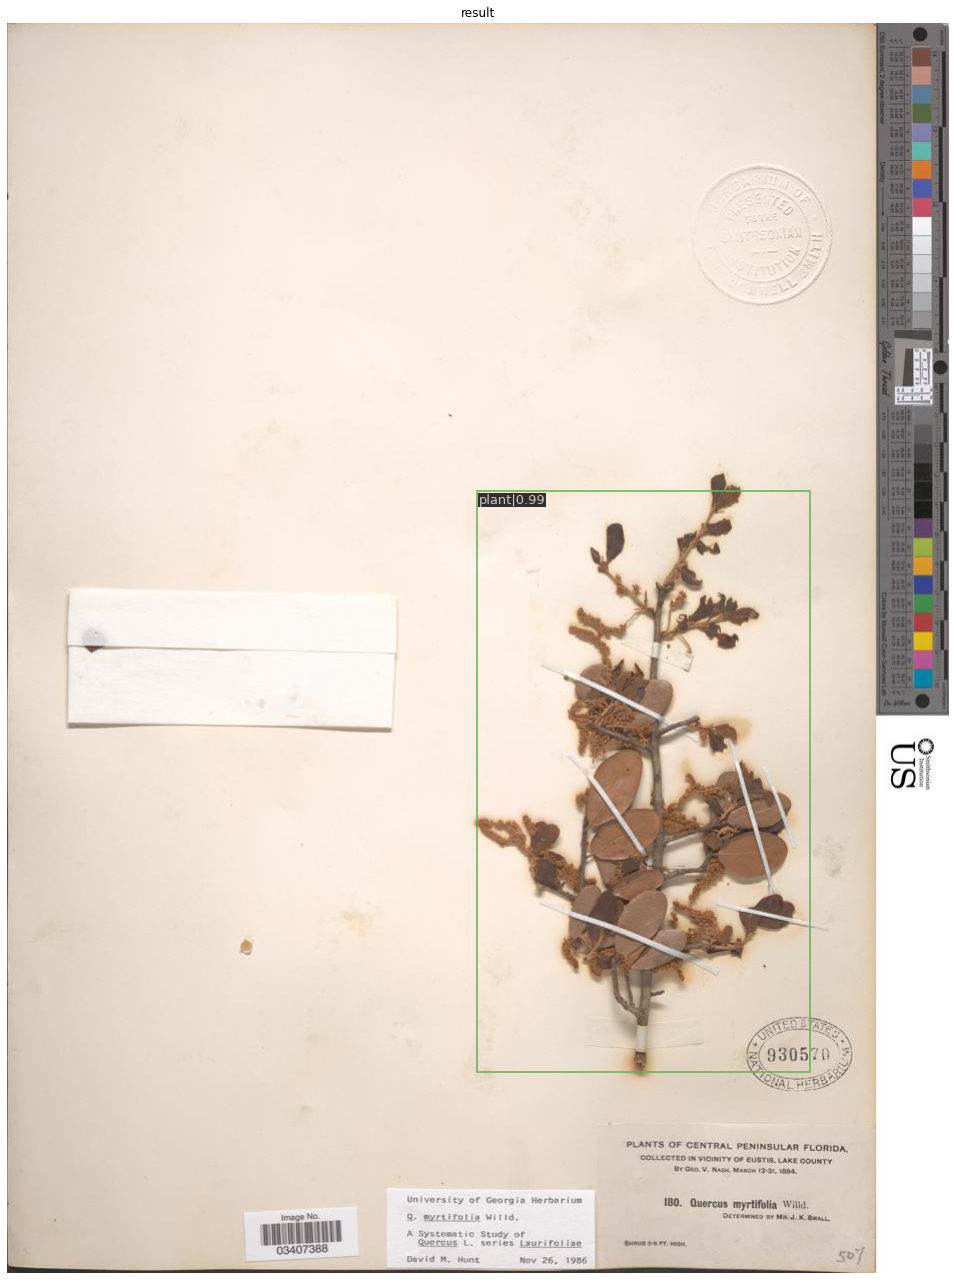

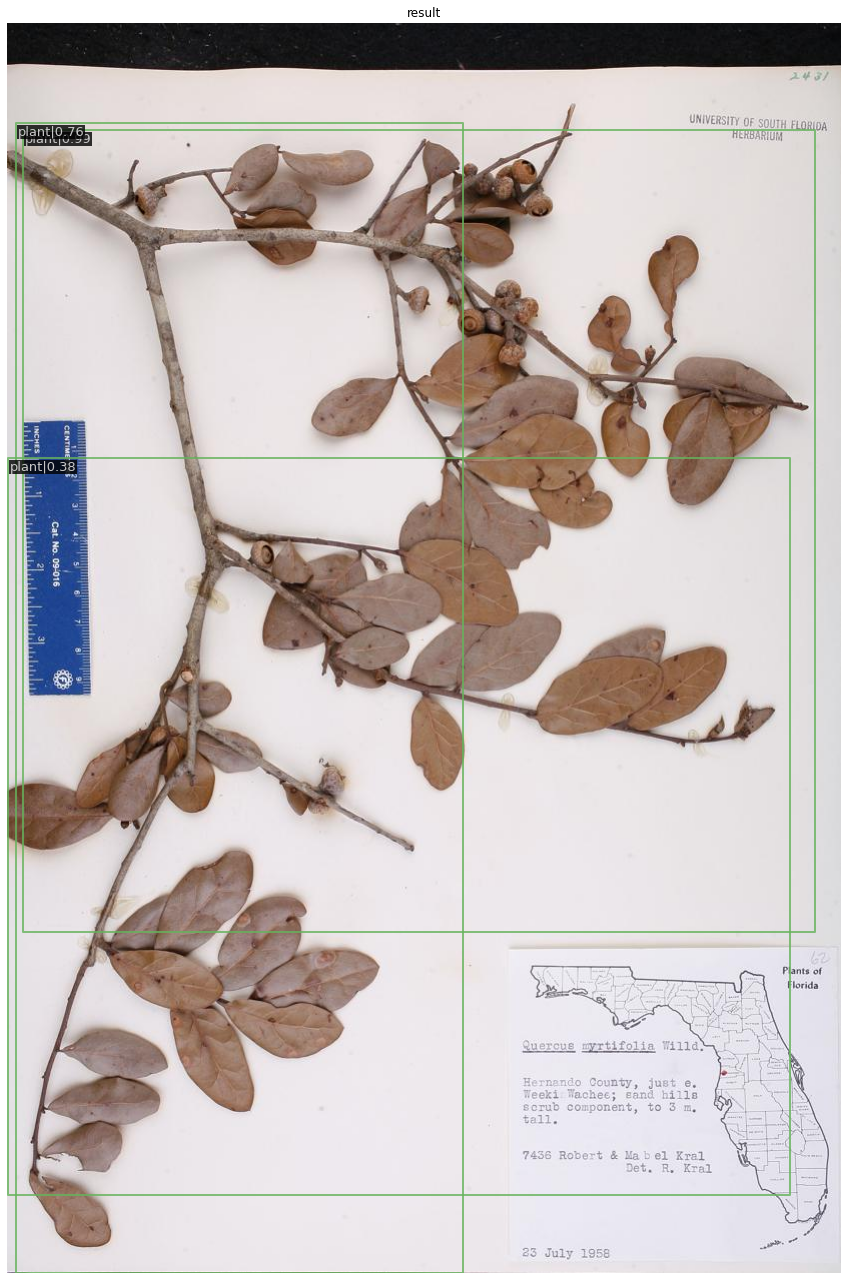

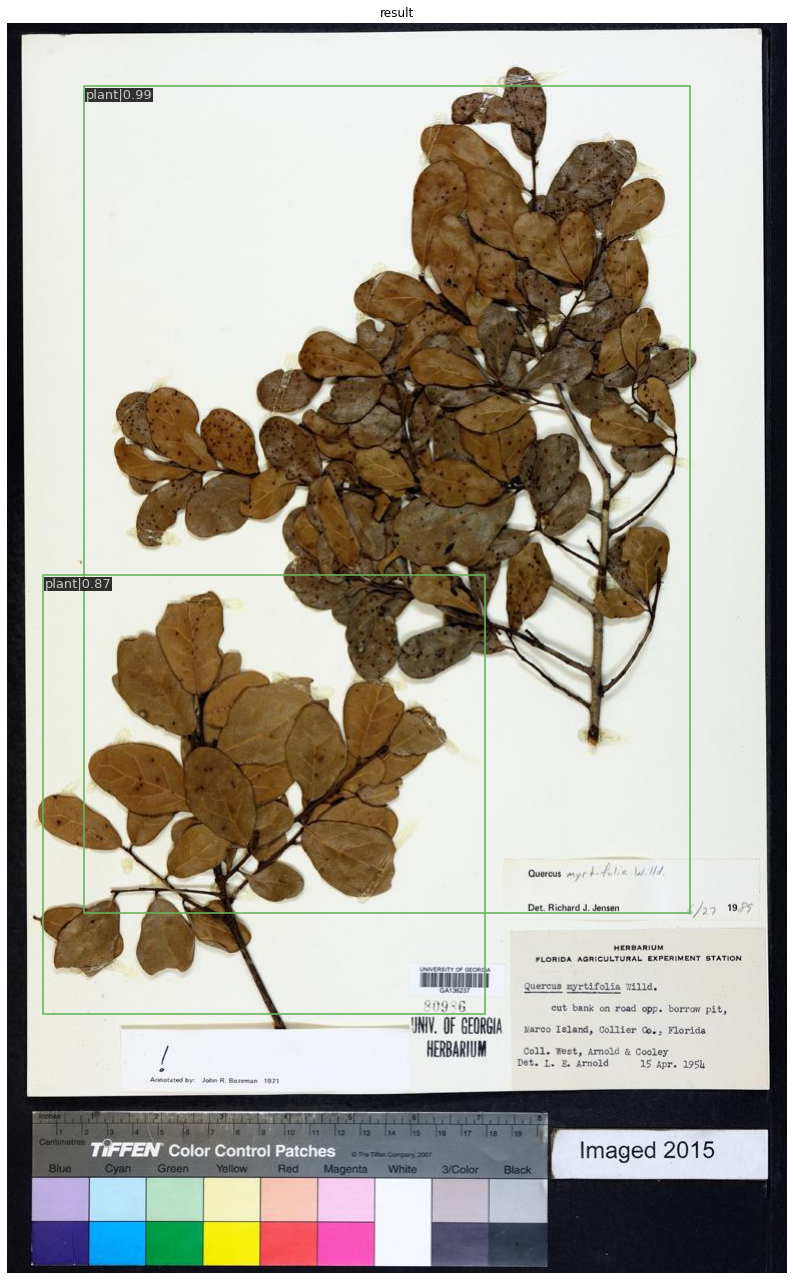

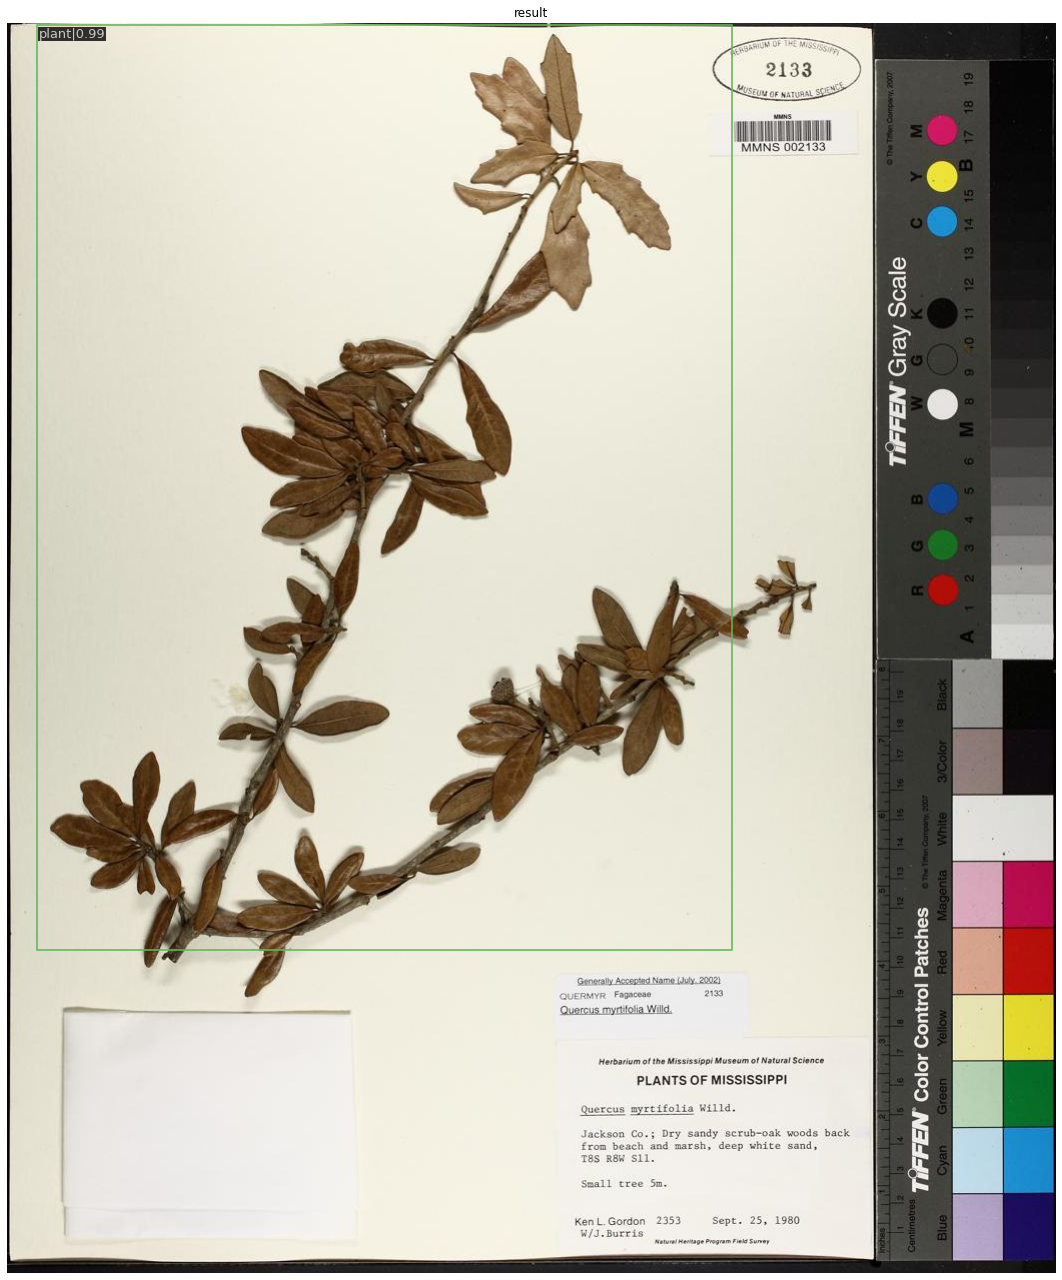

In [21]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
from glob import glob

model.cfg = cfg

for fn in list(glob("/content/train/**/*.jpg", recursive=True))[:5]:
  img = mmcv.imread(fn)
  result = inference_detector(model, img)
  show_result_pyplot(model, img, result)

In [18]:
! zip -0 /content/drive/MyDrive/UNC/S2022P/mmdet_bbox_model.zip /content/tutorial_exps/latest.pth

  adding: content/tutorial_exps/latest.pth (stored 0%)


In [22]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {0, 2, 1, 3}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {0, 2, 1, 3}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [23]:
def merge_boxes(box1, box2):
    return [min(box1[0], box2[0]), 
         min(box1[1], box2[1]), 
         max(box1[2], box2[2]),
         max(box1[3], box2[3])]

In [30]:
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
import os
from glob import glob
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
import cv2
import rectangle_packing_solver as rps

try:
  os.makedirs("/content/classif_images/")
except FileExistsError:
  pass
model.cfg = cfg

for fn in list(glob("/content/train/**/*.jpg"))[:10]:
  img = mmcv.imread(fn)
  bn = osp.basename(fn).replace(".jpg", "")
  result = inference_detector(model, img)
  np.set_printoptions(formatter={'float_kind':'{:25f}'.format})
  result = np.array(result)
  result = np.reshape(result, (-1, 5))

  bboxes = [list(v[:4]) for v in result]
  nbbox = []

  len_bbox = len(bboxes)
  while True: #bigger loop hierarchy
    idx = 0
    while True: #smaller x loop over single pass
      if idx >= len(bboxes):
        break

      while True:
        merged = False
        bb = bboxes.pop(idx)
        for idy in range(len(bboxes)):
          if get_iou(bb, bboxes[idy]) > 0.01:
            remove_b = bboxes.pop(idy)
            bboxes.append(merge_boxes(bb, remove_b))
            idx = 0
            merged = True
            break
        else:
          bboxes.append(bb)
          idx += 1
        
        if not merged:
          break
      
    if len(bboxes) < len_bbox:
      len_bbox = len(bboxes)
    else:
      break

  im = Image.open(fn)
  im_partitions = []
  for bb in bboxes:
    im_partitions.append(im.crop(bb))
  
  print(bn, len(im_partitions))

  if len(im_partitions) > 1:
    rects = []
    for imp in im_partitions:
      rects.append({"width": imp.width, "height": imp.height, "rotatable": True})
      problem = rps.Problem(rectangles=rects)
    
    print(rects)

    solution = rps.Solver().solve(problem=problem)
    print(solution)
    continue
  else:
    im2 = im_partitions[0]

  im2.save(f"/content/classif_images/{bn}.jpg")

3709969504 1
2397776225 1
1503250585 1
3709993887 1
3707752550 1
1503220577 1
1849191373 2
[{'width': 36, 'height': 38, 'rotatable': True}, {'width': 663, 'height': 786, 'rotatable': True}]
Solution({'sequence_pair': SequencePair(([1, 0], [1, 0])), 'floorplan': Floorplan({'positions': [{'id': 0, 'x': 786, 'y': 0, 'width': 36, 'height': 38}, {'id': 1, 'x': 0, 'y': 0, 'width': 786, 'height': 663}], 'bounding_box': (822, 663), 'area': 544986})})
2234366841 1
1503247146 1
1928142539 1


In [ ]:
! zip -r -q -0 /content/drive/MyDrive/UNC/S2022P/quercus_leaves.zip /content/classif_images/

In [ ]:
!cp /content/peltandra_leaves.zip /content/drive/MyDrive/UNC/peltandra_leaves.zip

In [ ]:
from google.colab import files
files.download('/content/checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>